Etapy:
- Sekwencjonowanie -> pliki FASTQ
- Kontrola jakości odczytów (Rsubread, funkcja qualityScores)
- Dopasowanie/mapowanie fragmentów (Rsubread, kilka funkcji począwszy od buildindex)

Efekt: Zliczenia występowania każdego genu (sekwencji nt) w kolejnych próbkach 

<h3> Analiza statystyczna danych RNA-Seq

<h4> Dane

In [1]:
library(edgeR)

Warning message:
"package 'edgeR' was built under R version 3.6.2"Loading required package: limma
Warning message:
"package 'limma' was built under R version 3.6.2"

In [2]:
zliczenia =  read.delim("counts.txt", row.names = 1) #zliczenia; dane dotyczą roslin
head(zliczenia)

,C61,C62,C63,C64,C91,C92,C93,C94,I561,I562,...,I593,I594,I861,I862,I863,I864,I891,I892,I893,I894
AT1G01010,341,371,275,419,400,542,377,372,677,522,...,691,500,157,473,459,228,590,491,565,496
AT1G01020,164,94,176,155,200,183,166,115,172,157,...,163,185,46,162,119,53,172,212,169,157
AT1G03987,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AT1G01030,20,34,40,27,28,36,22,40,20,7,...,17,26,49,17,24,48,27,28,47,32
AT1G01040,738,487,610,690,945,1033,836,908,857,821,...,871,756,361,618,641,439,783,692,768,625
AT1G03993,1,0,0,0,0,0,0,1,3,0,...,0,0,0,1,0,1,3,2,1,1


In [3]:
summary(zliczenia)

      C61              C62                C63               C64          
 Min.   :     0   Min.   :     0.0   Min.   :    0.0   Min.   :     0.0  
 1st Qu.:     0   1st Qu.:     0.0   1st Qu.:    0.0   1st Qu.:     0.0  
 Median :    53   Median :    46.0   Median :   55.0   Median :    57.0  
 Mean   :   437   Mean   :   377.4   Mean   :  371.5   Mean   :   424.4  
 3rd Qu.:   367   3rd Qu.:   301.0   3rd Qu.:  327.0   3rd Qu.:   367.0  
 Max.   :156315   Max.   :162891.0   Max.   :76187.0   Max.   :109827.0  
      C91               C92                C93               C94          
 Min.   :    0.0   Min.   :     0.0   Min.   :    0.0   Min.   :     0.0  
 1st Qu.:    0.0   1st Qu.:     0.0   1st Qu.:    0.0   1st Qu.:     0.0  
 Median :   59.0   Median :    56.0   Median :   57.0   Median :    48.0  
 Mean   :  404.5   Mean   :   456.2   Mean   :  402.2   Mean   :   354.7  
 3rd Qu.:  362.0   3rd Qu.:   384.0   3rd Qu.:  346.0   3rd Qu.:   296.0  
 Max.   :54582.0   Max.   :14091

In [4]:
dim(zliczenia)

[1] 32833    24

In [5]:
nrow(zliczenia)*ncol(zliczenia) #tyle mamy wartości

[1] 787992

Problem (szeroki zakres dynamiczny)

In [6]:
p1 = zliczenia[,1] #pierwsza probka
p1s = sort(zliczenia[,1], decreasing = TRUE) #posortowana pierwsza probka

In [7]:
sum(p1s[1:300]); sum(p1s[1:300])*100/sum(p1s) #mniej niz 1% genow sklada się na ponad 25% wszystkich odczytów (readów)

[1] 3640970

[1] 25.37612

Spójrzmy na rozkład 

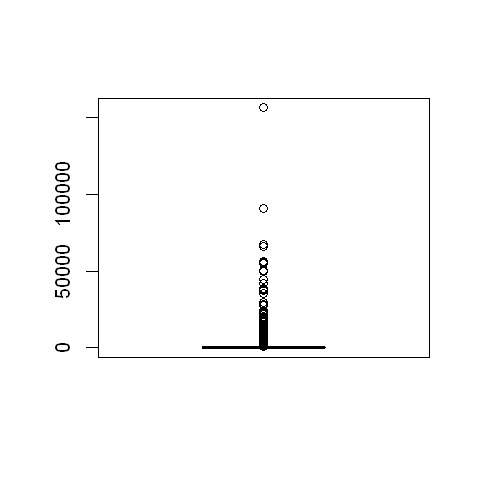

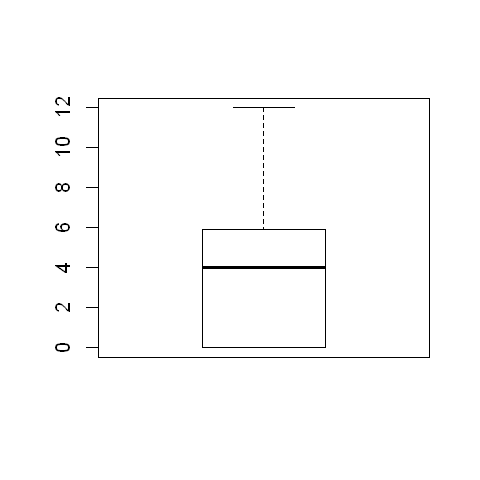

In [8]:
options(repr.plot.width=4, repr.plot.height=4)
boxplot(p1); boxplot(log(p1 + 1)) #zliczenia dla C61

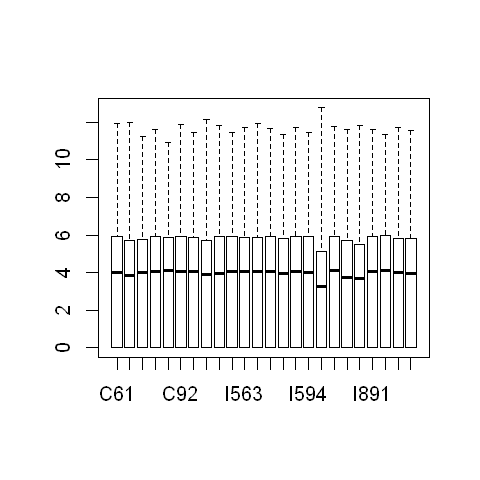

In [9]:
boxplot(log(zliczenia + 1)) #dla wszystkich próbek, zwrocic uwage na 17 obserwacje i potem norm.factor/boxplot --> bardziej normalne

Będzie nas interesować odpowiedź na pytanie - które geny (sekwencje) są różnicujące pomiędzy wskazanymi grupami?

Powiedzmy, że chce porównać I56 z I59. 

In [10]:
ktore_geny = c()
p_values = c()

for (i in 1:32833){
    c6 = zliczenia[i,][,c(9,10,11,12)]
    c9 = zliczenia[i,][,c(13,14,15,16)]
    if (sum(c6)>0 & sum(c9)>0){
            p = t.test(x = c6, y =c9, conf.level = 0.95)$p.value
        if (!is.nan(p)){
            if (p < 0.05){
                ktore_geny = append(ktore_geny,rownames(zliczenia[i,]))
                p_values = append(p_values, p)
            }    
        }
        
    }
}



In [11]:
length(ktore_geny)

[1] 5647

In [12]:
t = data.frame(geny = ktore_geny[order(p_values)], P = p_values[order(p_values)])
head(t)

geny,P
AT5G54930,3.413633e-07
AT3G01850,7.130621e-06
AT5G25110,8.406646e-06
AT1G17400,1.160966e-05
AT3G03700,1.169348e-05
AT1G12160,1.175051e-05


I po analizie? :)

<h4> Preprocessing

In [13]:
probki = colnames(zliczenia) #nazwy kolumn (tutaj: probki)
probki

[1] "C61"  "C62"  "C63"  "C64"  "C91"  "C92"  "C93"  "C94"  "I561" "I562"
[11] "I563" "I564" "I591" "I592" "I593" "I594" "I861" "I862" "I863" "I864"
[21] "I891" "I892" "I893" "I894"

In [14]:
odmiana = substr(probki, 1, nchar(probki) - 2) # nazwy odmian
czas =  substr(probki, nchar(probki) - 1, nchar(probki) - 1)  #moment czasowy
odmiana; czas

[1] "C"  "C"  "C"  "C"  "C"  "C"  "C"  "C"  "I5" "I5" "I5" "I5" "I5" "I5" "I5"
[16] "I5" "I8" "I8" "I8" "I8" "I8" "I8" "I8" "I8"

[1] "6" "6" "6" "6" "9" "9" "9" "9" "6" "6" "6" "6" "9" "9" "9" "9" "6" "6" "6"
[20] "6" "9" "9" "9" "9"

In [15]:
grupy = interaction(odmiana, czas)
print(grupy)

 [1] C.6  C.6  C.6  C.6  C.9  C.9  C.9  C.9  I5.6 I5.6 I5.6 I5.6 I5.9 I5.9 I5.9
[16] I5.9 I8.6 I8.6 I8.6 I8.6 I8.9 I8.9 I8.9 I8.9
Levels: C.6 I5.6 I8.6 C.9 I5.9 I8.9


In [16]:
sum(zliczenia$C61) #suma wszystkich zliczen dla C61

[1] 14348015

In [17]:
dane = DGEList(zliczenia) #tworzymy obiekt typu DGE
head(dane)

An object of class "DGEList"
$counts
          C61 C62 C63 C64 C91  C92 C93 C94 I561 I562 I563 I564 I591 I592 I593
AT1G01010 341 371 275 419 400  542 377 372  677  522  455  508  821  466  691
AT1G01020 164  94 176 155 200  183 166 115  172  157  122  152  189  171  163
AT1G03987   0   0   0   0   0    0   0   0    0    0    0    0    0    0    0
AT1G01030  20  34  40  27  28   36  22  40   20    7   57   38   25   10   17
AT1G01040 738 487 610 690 945 1033 836 908  857  821  770  751  848  607  871
AT1G03993   1   0   0   0   0    0   0   1    3    0    1    1    1    0    0
          I594 I861 I862 I863 I864 I891 I892 I893 I894
AT1G01010  500  157  473  459  228  590  491  565  496
AT1G01020  185   46  162  119   53  172  212  169  157
AT1G03987    0    0    0    0    0    0    0    0    0
AT1G01030   26   49   17   24   48   27   28   47   32
AT1G01040  756  361  618  641  439  783  692  768  625
AT1G03993    0    0    1    0    1    3    2    1    1

$samples
    group lib.size norm.factors
C61     1 14348015            1
C62     1 12389489            1
C63     1 12197016            1
C64     1 13933406            1
C91     1 13280511            1
19 more rows ...

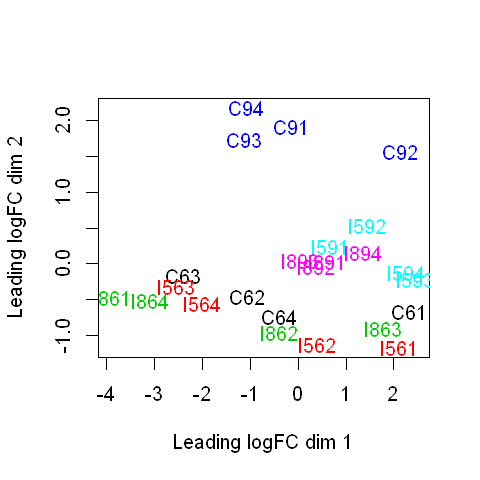

In [18]:
options(repr.plot.width=4, repr.plot.height=4)
plotMDS(dane, col = as.numeric(grupy)) #"troche takie PCA", kolory wg grup

<h4> Normalizacja TMM


In [19]:
dane = calcNormFactors(dane) #wyznacza czynniki normalizacji (normalization factors); stosujemy normalizacje TMM -> cel: lepsze porownywanie pomiedzy probkami oraz zredukowac efekt występowania wysokiej ekspresji małej grupy genów w jednym eksperymencie (ale nie w innych) 
dane

,C61,C62,C63,C64,C91,C92,C93,C94,I561,I562,...,I593,I594,I861,I862,I863,I864,I891,I892,I893,I894
AT1G01010,341,371,275,419,400,542,377,372,677,522,...,691,500,157,473,459,228,590,491,565,496
AT1G01020,164,94,176,155,200,183,166,115,172,157,...,163,185,46,162,119,53,172,212,169,157
AT1G03987,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AT1G01030,20,34,40,27,28,36,22,40,20,7,...,17,26,49,17,24,48,27,28,47,32
AT1G01040,738,487,610,690,945,1033,836,908,857,821,...,871,756,361,618,641,439,783,692,768,625
AT1G03993,1,0,0,0,0,0,0,1,3,0,...,0,0,0,1,0,1,3,2,1,1
AT1G01046,1,1,6,4,5,3,0,2,4,4,...,9,1,0,4,1,3,5,7,2,5
AT1G01050,1515,1091,1136,1285,1485,1581,1205,994,1326,1595,...,1522,1666,442,1423,1117,669,1512,1646,1313,1249
AT1G03997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AT1G01060,2867,2676,3079,2851,5513,6646,7596,7318,2439,1946,...,4718,4006,1559,1628,1559,1559,4146,5040,4922,3828


In [20]:
dane$samples

,group,lib.size,norm.factors
C61,1,14348015,1.0466541
C62,1,12389489,0.9517416
C63,1,12197016,1.0535991
C64,1,13933406,1.0424665
C91,1,13280511,1.0943189
C92,1,14978718,1.0623834
C93,1,13207167,1.0273956
C94,1,11646163,0.9887328
I561,1,14664605,1.0140387
I562,1,13908368,1.0697136


In [21]:
summary(dane$samples)

 group     lib.size         norm.factors   
 1:24   Min.   : 8551250   Min.   :0.7208  
        1st Qu.:12713736   1st Qu.:0.9829  
        Median :13909230   Median :1.0265  
        Mean   :13298289   Mean   :1.0032  
        3rd Qu.:14200710   3rd Qu.:1.0435  
        Max.   :15543372   Max.   :1.0943  

<h4> CPM = Counts Per Million = czyli dzielimy zliczenia przez rozmiar biblioteki i mnożymy przez milion

In [22]:
#odrzucamy te geny ktore mają malo zliczen

prog =  1 #kwestia umowna 
d = which(apply(cpm(dane), 1, max) < prog) #ktore mają maksymalne CPM w wierszu mniejsze od 1?
dane2 = dane[-d,] 
dim(dane2) #ile genow pozostalo

[1] 21081    24

In [23]:
head(dane2)

An object of class "DGEList"
$counts
           C61  C62  C63  C64  C91  C92  C93  C94 I561 I562 I563 I564 I591 I592
AT1G01010  341  371  275  419  400  542  377  372  677  522  455  508  821  466
AT1G01020  164   94  176  155  200  183  166  115  172  157  122  152  189  171
AT1G01030   20   34   40   27   28   36   22   40   20    7   57   38   25   10
AT1G01040  738  487  610  690  945 1033  836  908  857  821  770  751  848  607
AT1G01050 1515 1091 1136 1285 1485 1581 1205  994 1326 1595 1046 1097 1453 1424
AT1G01060 2867 2676 3079 2851 5513 6646 7596 7318 2439 1946 2444 2488 5078 3368
          I593 I594 I861 I862 I863 I864 I891 I892 I893 I894
AT1G01010  691  500  157  473  459  228  590  491  565  496
AT1G01020  163  185   46  162  119   53  172  212  169  157
AT1G01030   17   26   49   17   24   48   27   28   47   32
AT1G01040  871  756  361  618  641  439  783  692  768  625
AT1G01050 1522 1666  442 1423 1117  669 1512 1646 1313 1249
AT1G01060 4718 4006 1559 1628 1559 1559 4146 5040 4922 3828

$samples
    group lib.size norm.factors
C61     1 14348015    1.0466541
C62     1 12389489    0.9517416
C63     1 12197016    1.0535991
C64     1 13933406    1.0424665
C91     1 13280511    1.0943189
19 more rows ...

<h4> Jak wyglądają zliczenia (dla dane2)?

In [24]:
summary(dane2$counts[,1]) #dla pierwszej probki

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
     0.0     65.0    236.0    680.4    644.0 156315.0 

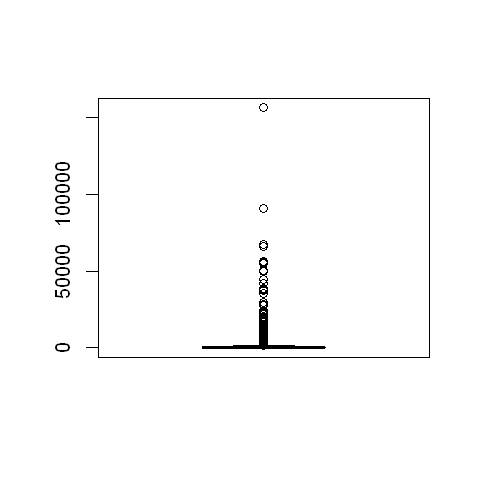

In [25]:
boxplot(dane2$counts[,1]) 

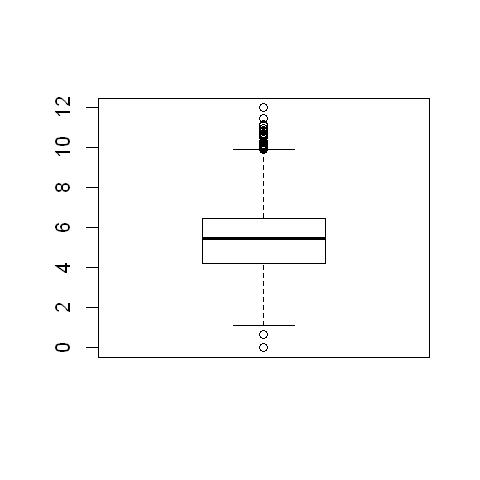

In [26]:
boxplot(log(dane2$counts[,1]+1))

In [27]:
summary(log2(dane2$counts[,1])) #skąd te nieskonczonosci?

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   -Inf   6.022   7.883    -Inf   9.331  17.254 

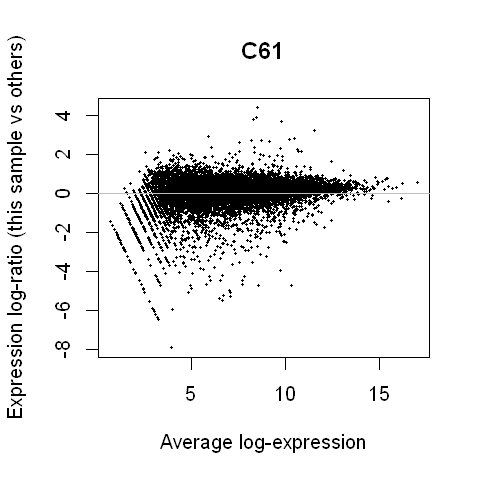

In [28]:
plotMD(log2(dane2$counts), column = 1) #tutaj dla pierwszej  (porównuje tę probke z pozostalymi)
abline(h=0, col="grey")

In [29]:
m =  model.matrix(~ 0 + grupy) #macierz dla tego eksperymentu
m; nrow(m); ncol(m) #6 kolumn bo tyle kategorii, 24 wierszy bo 6*4, gdzie 4-liczba powtorzen dla kazdej sytuacji

grupyC.6,grupyI5.6,grupyI8.6,grupyC.9,grupyI5.9,grupyI8.9
1,0,0,0,0,0
1,0,0,0,0,0
1,0,0,0,0,0
1,0,0,0,0,0
0,0,0,1,0,0
0,0,0,1,0,0
0,0,0,1,0,0
0,0,0,1,0,0
0,1,0,0,0,0
0,1,0,0,0,0


[1] 24

[1] 6

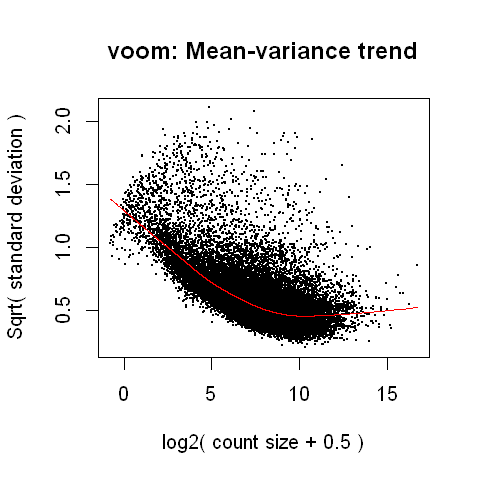

In [30]:
options(repr.plot.width=4, repr.plot.height=4)
y = voom(dane2, m, plot = T)

In [31]:
y #dane zostaly przerobione na logCPM (E); za pomocą związku między średnią a wariancją oszacowano wagi (dla kazdej obserwacji; potrzebne pozniej przy budowie modelu liniowego - problem z równą wariancją czyli Heteroskedastyczność

,group,lib.size,norm.factors
C61,1,15017409,1.0466541
C62,1,11791592,0.9517416
C63,1,12850765,1.0535991
C64,1,14525109,1.0424665
C91,1,14533114,1.0943189
C92,1,15913141,1.0623834
C93,1,13568985,1.0273956
C94,1,11514943,0.9887328
I561,1,14870476,1.0140387
I562,1,14877970,1.0697136


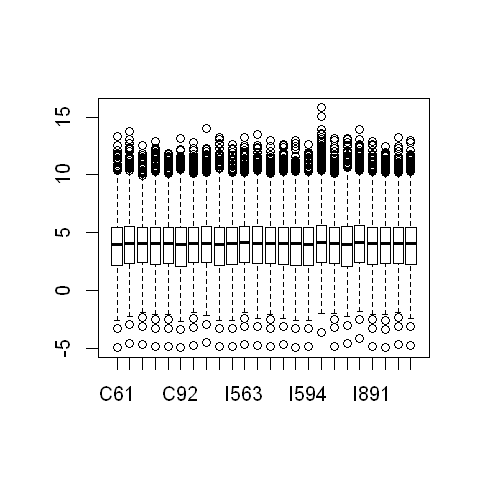

In [32]:
boxplot(y$E) #wykresy rozkaldow logCPM dla kolejnych probek; czy nas dziwi ze niemal ta sama mediana?

In [33]:
log2((341*10^6)/(14348015*1.0466541)) #pierwszy gen, pierwsza probka <--log2CPM #troche sie rozni, bo 2/L (https://bioconductor.org/packages/devel/workflows/vignettes/RNAseq123/inst/doc/limmaWorkflow.html)

[1] 4.505064

In [34]:
log2(((341+0.5)*10^6)/(14348015*1.0466541)) #pierwszy gen, pierwsza probka <--dodajemy 0.5 zeby uniknąc zerowania pod logarytmem

[1] 4.507178

In [35]:
y$E["AT1G01010",]

C61      C62      C63      C64      C91      C92      C93      C94 
4.507178 4.977532 4.422126 4.852050 4.784386 5.091333 4.798092 5.015661 
    I561     I562     I563     I564     I591     I592     I593     I594 
5.509698 5.134181 5.100193 5.241407 5.810976 5.139204 5.506983 5.066696 
    I861     I862     I863     I864     I891     I892     I893     I894 
4.675421 5.049866 5.221708 4.683481 5.344888 5.006247 5.429339 5.212980

In [36]:
mean(y$E["AT1G01010",]); sd(y$E["AT1G01010",])

[1] 5.065901

[1] 0.3284568

In [37]:
log2(sum(as.vector(y$E["AT1G01010",])*as.vector(y$weights[1:24]))+0.5)

[1] 10.86343

In [38]:
sdd = c()
meann = c()
for (i in 1:21081){
    sdd = append(sdd, sqrt(sd(as.vector(y$E[i,]))))
    meann = append(meann, mean(as.vector(y$E[i,])))
}

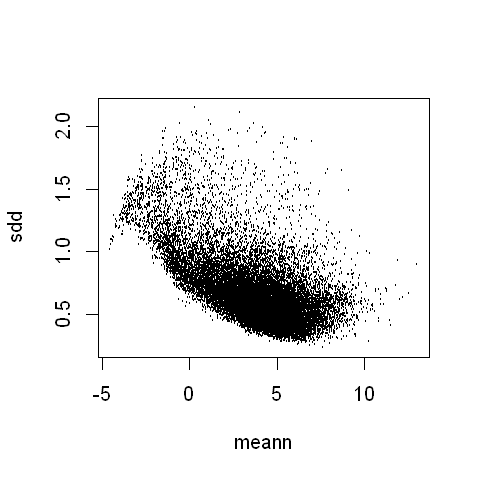

In [39]:
plot(meann, sdd, cex = 0.1)

In [40]:
length(y$weights)

[1] 505944

In [41]:
21081*4*6 #liczba genow*24 kolumny

[1] 505944

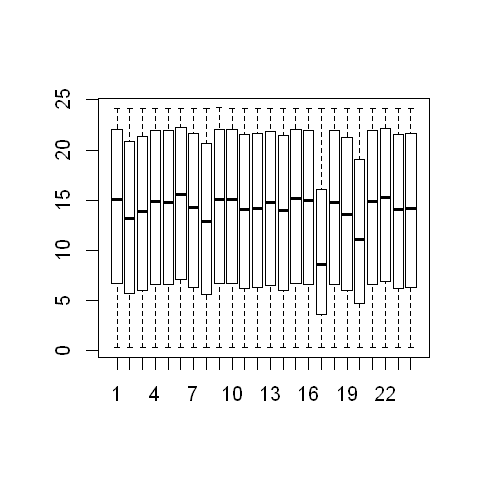

In [42]:
boxplot(y$weights)

<h3> Regresja liniowa + Bayes

<h4> Budowa modelu liniowego

In [43]:
fit = lmFit(y, m) #buduje model liniowy dla kazdego genu
head(coef(fit))

,grupyC.6,grupyI5.6,grupyI8.6,grupyC.9,grupyI5.9,grupyI8.9
AT1G01010,4.685920,5.2477564,4.938939,4.922501,5.382619,5.246093
AT1G01020,3.420726,3.4147535,3.130644,3.571855,3.610579,3.655254
AT1G01030,1.111114,0.7316936,1.435521,1.157532,0.388736,1.222892
AT1G01040,5.534792,5.8249589,5.645188,6.071787,5.721339,5.667081
AT1G01050,6.530907,6.4688536,6.394305,6.554009,6.707946,6.660336
AT1G01060,7.732309,7.3622888,7.317480,8.932463,8.193361,8.308331


In [44]:
#wstawka (dla pierwszego genu)
summary(lmodel <- lm(as.vector(y$E["AT1G01010",])~grupy)) #czyli przewidujemy logCPM w oparciu o grupy (zmienne kategoryczne)


Call:
lm(formula = as.vector(y$E["AT1G01010", ]) ~ grupy)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.31427 -0.19294 -0.02017  0.16399  0.43001 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   4.6897     0.1220  38.431  < 2e-16 ***
grupyI5.6     0.5566     0.1726   3.226  0.00469 ** 
grupyI8.6     0.2179     0.1726   1.263  0.22284    
grupyC.9      0.2326     0.1726   1.348  0.19435    
grupyI5.9     0.6912     0.1726   4.005  0.00083 ***
grupyI8.9     0.5586     0.1726   3.237  0.00457 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2441 on 18 degrees of freedom
Multiple R-squared:  0.5679,	Adjusted R-squared:  0.4479 
F-statistic: 4.732 on 5 and 18 DF,  p-value: 0.006196


In [45]:
4.6897+0.5586 #dla I8.9        

[1] 5.2483

In [46]:
fit["AT5G37260",]$coefficients #wspolczynniki dla wybranego genu

,grupyC.6,grupyI5.6,grupyI8.6,grupyC.9,grupyI5.9,grupyI8.9
AT5G37260,5.102284,5.372745,5.144123,9.469451,8.536264,8.03395


In [47]:
8.536264-5.372745 #logFC dla groupI5.9 i groupI5.6

[1] 3.163519

In [48]:
#Intuicja za tym stojąca
dane2["AT5G37260",]$counts[,9:12]; dane2["AT5G37260",]$counts[,13:16]

I561 I562 I563 I564 
 571  557  627  585

I591 I592 I593 I594 
5833 5251 5359 5083

In [49]:
i56 = mean(c(571, 557, 627, 585))
i59 = mean(c(5833, 5251, 5359, 5083))

FC = i59/i56 #FC (fold change)
i56; i59; FC; log2(FC) #mniej wiecej to co wyzej

[1] 585

[1] 5381.5

[1] 9.199145

[1] 3.2015

Powiedzmy, że chce porównać I59 oraz I56

In [50]:
contr =  makeContrasts(grupyI5.9 - grupyI5.6, levels = colnames(coef(fit)))
contr

,grupyI5.9 - grupyI5.6
grupyC.6,0
grupyI5.6,-1
grupyI8.6,0
grupyC.9,0
grupyI5.9,1
grupyI8.9,0


In [51]:
tmp = contrasts.fit(fit, contr)
tmp = eBayes(tmp)
top.table = topTable(tmp, sort.by = "P", n = Inf)
head(top.table, 20)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
AT5G37260,3.1635185,6.939588,23.940809,1.437434e-16,3.030255e-12,26.418596
AT3G02990,1.6464375,3.190750,13.156564,1.610004e-11,1.697025e-07,15.509886
AT2G29500,-5.2889981,5.471250,-11.940534,9.584101e-11,6.218818e-07,14.454410
AT3G24520,1.9066904,5.780286,11.804606,1.179985e-10,6.218818e-07,14.527209
AT5G65630,1.0705500,7.455294,10.867404,5.208111e-10,2.195844e-06,13.127007
AT3G46230,-7.0674751,4.413795,-10.718544,6.649402e-10,2.336268e-06,11.717332
AT4G21320,-2.8931736,4.587374,-10.073345,1.972455e-09,5.369767e-06,11.707489
AT5G48570,-4.1285339,6.333766,-10.054440,2.037766e-09,5.369767e-06,11.774326
AT5G52882,0.8895868,7.561378,9.800636,3.168378e-09,6.809179e-06,11.376961
AT3G24100,-1.3746167,5.993600,-9.789657,3.230007e-09,6.809179e-06,11.358325


In [52]:
results = as.data.frame(top.table) 
head(results)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
AT5G37260,3.163518,6.939588,23.94081,1.437434e-16,3.030255e-12,26.41860
AT3G02990,1.646438,3.190750,13.15656,1.610004e-11,1.697025e-07,15.50989
AT2G29500,-5.288998,5.471250,-11.94053,9.584101e-11,6.218818e-07,14.45441
AT3G24520,1.906690,5.780286,11.80461,1.179985e-10,6.218818e-07,14.52721
AT5G65630,1.070550,7.455294,10.86740,5.208111e-10,2.195844e-06,13.12701
AT3G46230,-7.067475,4.413795,-10.71854,6.649402e-10,2.336268e-06,11.71733


In [53]:
1/(1+exp(-26.41)) #na tyle % gen ulega zroznicowanej ekspresji (https://support.bioconductor.org/p/6124/, https://www.bioconductor.org/packages/devel/bioc/vignettes/limma/inst/doc/usersguide.pdf B-statistics)

[1] 1

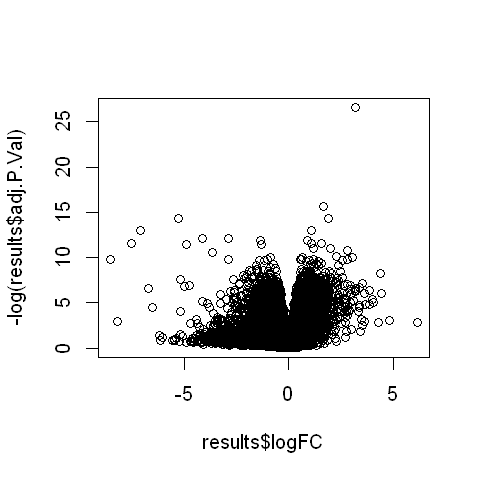

In [54]:
plot(results$logFC, -log(results$adj.P.Val))  

In [55]:
length(which(top.table$adj.P.Val < 0.05))

[1] 4529

In [56]:
top.table$Gene = rownames(top.table)
top.table = top.table[,c("Gene", names(top.table)[1:6])]
write.table(top.table, file = "time9_v_time6_I5.txt", row.names = F, sep = "\t", quote = F)

In [57]:
#tym razem miedzy I5.6 a C.6

contr = makeContrasts(grupyI5.6 - grupyC.6, levels = colnames(coef(fit)))
tmp = contrasts.fit(fit, contr)
tmp = eBayes(tmp)
top.table = topTable(tmp, sort.by = "P", n = Inf)
head(top.table, 20)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
AT4G12520,-10.2545558,0.3581132,-11.402477,2.206726e-10,4.651998e-06,3.6958152
AT3G30720,5.8174384,3.3950689,10.528934,9.108689e-10,9.601014e-06,7.9963406
AT5G26270,2.4210296,4.3788335,9.654257,4.101051e-09,2.881809e-05,10.8356224
AT3G33528,-4.7808138,-1.8612945,-7.454943,2.741289e-07,1.444728e-03,0.5677732
AT1G64795,-4.8725948,-1.3119360,-7.079643,5.985471e-07,2.523594e-03,1.8151705
AT3G05955,-4.1589395,-1.9731168,-6.730979,1.257443e-06,4.350078e-03,1.0346134
AT4G28100,-0.8100610,4.4653004,-6.666678,1.444454e-06,4.350078e-03,5.4207135
AT3G25730,1.3218472,3.8664692,6.099603,5.019911e-06,1.322809e-02,4.2289493
AT5G05480,-0.5053042,4.4870331,-5.654519,1.371309e-05,3.212063e-02,3.2846234
AT2G14878,-0.5320177,6.4332427,-5.522563,1.855037e-05,3.645200e-02,2.9424881


In [58]:
length(which(top.table$adj.P.Val < 0.05)) # number of DE genes

[1] 20

<h3> GLM (uogólnione modele liniowe)


Zakładamy ujemny rozkład dwumianowy (uogólnienie rozkładu Poissona), tzn $Y \sim NB(r, p)$

$D^2(Y) = \mu + k\mu^2$, k - dyspersja

Uwaga: Jeżeli $k = 0$, to $D^2(Y) = \mu$ (rozkład Poissona)

In [59]:
dgeObj = estimateCommonDisp(dane2) #dla wszystkich genów
dgeObj = estimateGLMTrendedDisp(dgeObj)
dgeObj =  estimateTagwiseDisp(dgeObj) #dla kazdego genu z osobna

troche za mało danych z punktu widzenia kazdego genu zeby aproksymowac isotnie dyspersje, dlatego korzystamy z globalnej --> jak duzo bibliotek, to nie ma problemu

$BCV = \sqrt{k}$

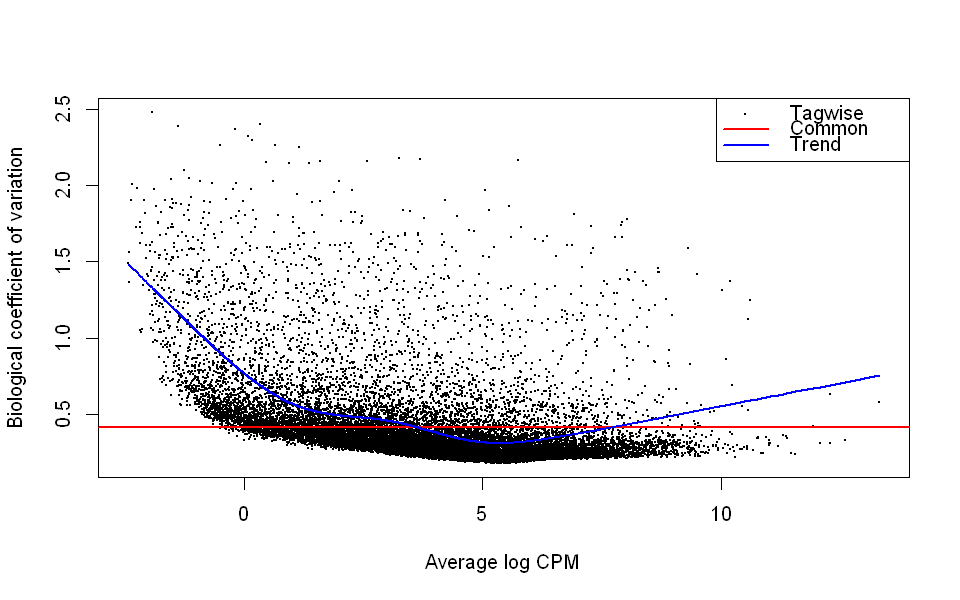

In [60]:
options(repr.plot.width=8, repr.plot.height=5)

plotBCV(dgeObj) #BCV opisuje zmiennosc pomiędzy replikatami, przykładowo BCV = 0.3 oznacza ze replikaty roznia sie miedzy sobą o ok 30% 

In [61]:
fit = glmFit(dgeObj, m)
names(fit)

[1] "coefficients"          "fitted.values"         "deviance"             
 [4] "method"                "counts"                "unshrunk.coefficients"
 [7] "df.residual"           "design"                "offset"               
[10] "dispersion"            "prior.count"           "samples"              
[13] "prior.df"              "AveLogCPM"

In [62]:
head(coef(fit))

,grupyC.6,grupyI5.6,grupyI8.6,grupyC.9,grupyI5.9,grupyI8.9
AT1G01010,-10.553332,-10.173217,-10.399569,-10.400158,-10.064324,-10.172424
AT1G01020,-11.433190,-11.448545,-11.653656,-11.339970,-11.310614,-11.282767
AT1G01030,-12.982532,-13.010666,-12.413479,-12.971808,-13.521278,-12.931118
AT1G01040,-9.978821,-9.778168,-9.888609,-9.601965,-9.846309,-9.881873
AT1G01050,-9.287429,-9.324568,-9.379964,-9.270249,-9.165003,-9.197657
AT1G01060,-8.452161,-8.703560,-8.696726,-7.604754,-8.128522,-8.050337


In [63]:
#porowanie C6 i C9
contr =  makeContrasts(grupyC.6 - grupyC.9, levels = colnames(coef(fit)))
lrt.pVsV = glmLRT(fit, contrast=contr)
topTags(lrt.pVsV)

,logFC,logCPM,LR,PValue,FDR
AT1G08430,7.236178,6.90256174,29.77687,4.847422e-08,0.0009267927
AT5G07570,7.620685,3.41494400,28.50666,9.337665e-08,0.0009267927
AT5G38200,5.113514,6.02070639,27.83829,1.318902e-07,0.0009267927
AT3G13950,5.280063,3.05220386,26.93744,2.101480e-07,0.0011075327
AT1G22770,7.441116,5.09250637,25.98806,3.435356e-07,0.0012055566
AT5G07572,7.429947,0.03955216,25.76580,3.854576e-07,0.0012055566
AT2G41380,4.671623,6.39381432,25.69285,4.003082e-07,0.0012055566
AT5G47000,6.492513,2.36316343,23.91768,1.005443e-06,0.0026494667
AT1G51830,5.211988,7.18016986,22.98396,1.633588e-06,0.0038264086
AT3G49580,6.108404,2.24801349,22.28366,2.351995e-06,0.0049582398


In [64]:
results = as.data.frame(topTags(lrt.pVsV, n = Inf))
head(results)

,logFC,logCPM,LR,PValue,FDR
AT1G08430,7.236178,6.90256174,29.77687,4.847422e-08,0.0009267927
AT5G07570,7.620685,3.41494400,28.50666,9.337665e-08,0.0009267927
AT5G38200,5.113514,6.02070639,27.83829,1.318902e-07,0.0009267927
AT3G13950,5.280063,3.05220386,26.93744,2.101480e-07,0.0011075327
AT1G22770,7.441116,5.09250637,25.98806,3.435356e-07,0.0012055566
AT5G07572,7.429947,0.03955216,25.76580,3.854576e-07,0.0012055566


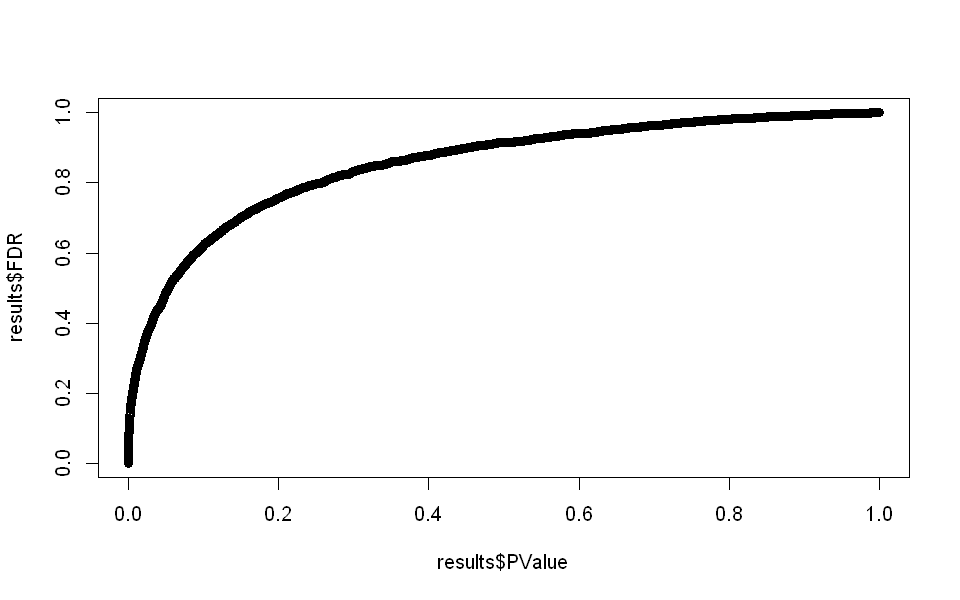

In [65]:
plot(results$PValue, results$FDR) #zaleznosc pomiędzy pvalue a FDR

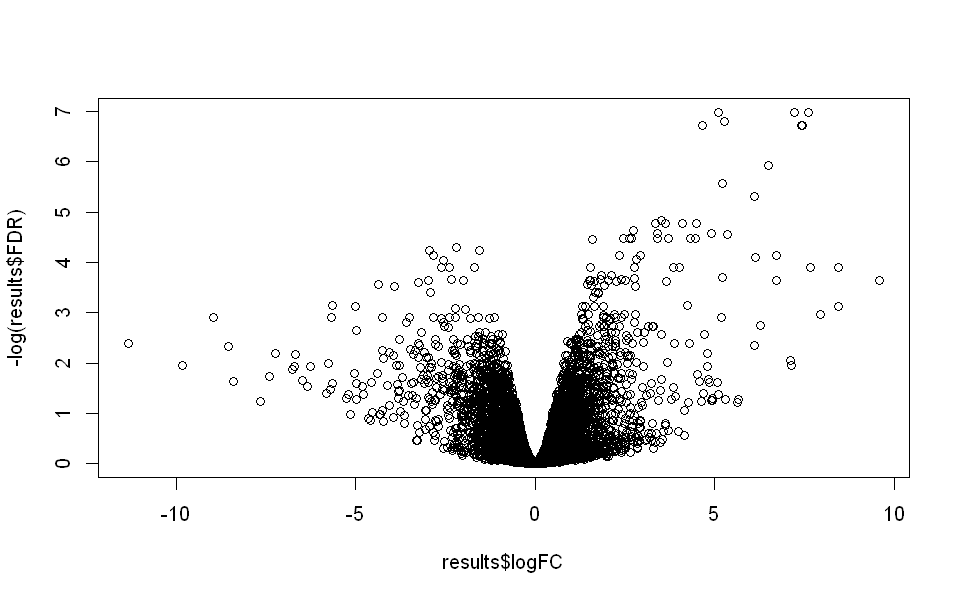

In [66]:
plot(results$logFC, -log(results$FDR)) #interpretacja: u góry po prawej UP, u góry po lewej DOWN

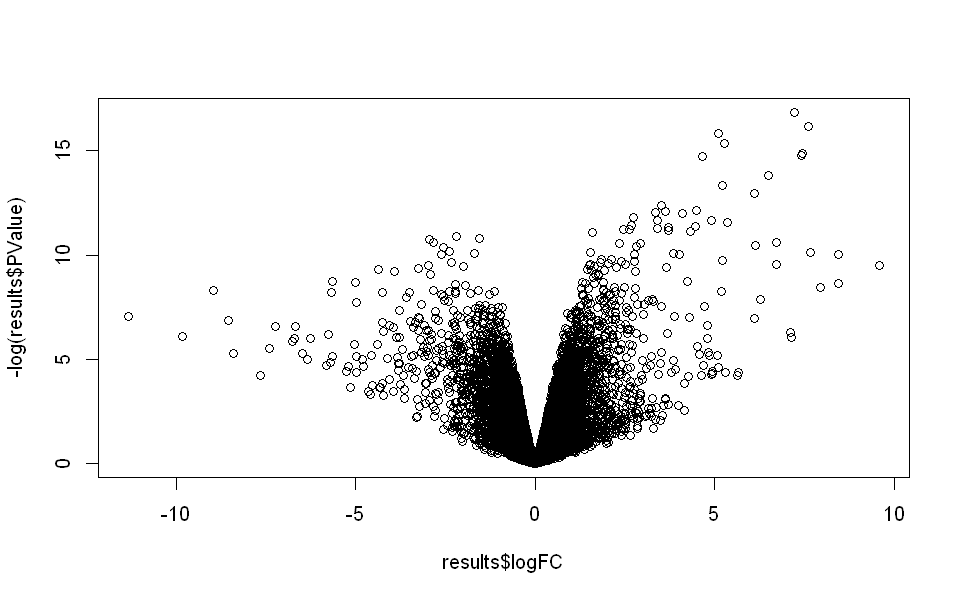

In [67]:
plot(results$logFC, -log(results$PValue))

Warto poczytać: https://www.bioconductor.org/packages/devel/bioc/vignettes/limma/inst/doc/usersguide.pdf